In [63]:
import os
import random
import pandas as pd
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch

from sklearn.model_selection import KFold, StratifiedKFold

from density_decoding.utils.data_utils import IBLDataLoader

from side_info_decoding.utils import (
    set_seed, 
    load_data_from_pids, 
    sliding_window_over_trials,
)

from side_info_decoding.reduced_rank import (
    Reduced_Rank_Model, 
    train_single_task, 
    model_eval
)

def time_bin_wise_metrics(y_true, y_pred):
    r2 = r2_score(y_true.flatten(), y_pred.flatten())
    adj_r2 = explained_variance_score(y_true, y_pred)
    return r2, adj_r2

def sliding_window_over_time(data, window_size=10):
    
    if len(data.shape) == 3:
        n_trials, n_units, n_t_bins = data.shape
        data_window = np.zeros((
            n_trials, n_units, n_t_bins - window_size + 1, window_size
        ))
        for t in range(window_size-1, n_t_bins):
            tmp_window = np.zeros((n_trials, n_units, window_size))
            for d in range(window_size):
                  tmp_window[:,:,d] = data[:,:,t - d]
            data_window[:,:,t-window_size] = tmp_window
    else:
        n_trials, n_t_bins = data.shape
        data_window = np.zeros((n_trials, n_t_bins - window_size + 1))
        for t in range(window_size-1, n_t_bins):
            data_window[:,t-window_size] = data[:,t]
    return data_window

%matplotlib inline
plt.rc("figure", dpi=200)
SMALL_SIZE = 10
BIGGER_SIZE = 10
plt.rc('font', size=BIGGER_SIZE)
plt.rc('axes', titlesize=BIGGER_SIZE)
plt.rc('axes', labelsize=BIGGER_SIZE)
plt.rc('axes', linewidth=.5)
plt.rc('xtick', labelsize=BIGGER_SIZE)
plt.rc('ytick', labelsize=BIGGER_SIZE)
plt.rc('legend', fontsize=SMALL_SIZE)
plt.rc('figure', titlesize=1)
plt.rcParams['xtick.major.size'] = 3
plt.rcParams['xtick.minor.size'] = 3
plt.rcParams['ytick.major.size'] = 3
plt.rcParams['ytick.minor.size'] = 3

In [5]:
dir_path = Path("/home/yizi/side_info_decoding/saved_results/connected_decoders")

pids = [f.name for f in os.scandir(dir_path) if f.is_dir() and f.name != ".ipynb_checkpoints"]

brain_regions = ["all", "po", "lp", "dg", "ca1", "vis"]
behaviors = ["choice", "prior"]
models = ["density_based", "multi_task_reduced_rank", "state_space_model"]

In [6]:
pids

['1a60a6e1-da99-4d4e-a734-39b1d4544fad',
 '0b8ea3ec-e75b-41a1-9442-64f5fbc11a5a',
 '84bb830f-b9ff-4e6b-9296-f458fb41d160',
 '143dd7cf-6a47-47a1-906d-927ad7fe9117',
 '1e176f17-d00f-49bb-87ff-26d237b525f1',
 '6fc4d73c-2071-43ec-a756-c6c6d8322c8b',
 '523f8301-4f56-4faf-ab33-a9ff11331118',
 '16799c7a-e395-435d-a4c4-a678007e1550',
 'ad714133-1e03-4d3a-8427-33fc483daf1a',
 '31f3e083-a324-4b88-b0a4-7788ec37b191',
 'dab512bd-a02d-4c1f-8dbc-9155a163efc0',
 'febb430e-2d50-4f83-87a0-b5ffbb9a4943']

In [2]:
from sklearn.metrics import r2_score, explained_variance_score
from scipy.stats import pearsonr
from sklearn.linear_model import Ridge

In [73]:
skf = KFold(n_splits=5, shuffle=True, random_state=666)

d = 3
pids = [
    "6fc4d73c-2071-43ec-a756-c6c6d8322c8b",
    # "1a60a6e1-da99-4d4e-a734-39b1d4544fad",
    # "dab512bd-a02d-4c1f-8dbc-9155a163efc0",
    # "febb430e-2d50-4f83-87a0-b5ffbb9a4943",
    # "84bb830f-b9ff-4e6b-9296-f458fb41d160",
    # "523f8301-4f56-4faf-ab33-a9ff11331118",
    # "143dd7cf-6a47-47a1-906d-927ad7fe9117",
]

for i, pid in enumerate(pids):

    ibl_data_loader = IBLDataLoader(
        pid, 
        n_t_bins = 30,
        behavior_type = "prior",
        prior_path = "/mnt/3TB/yizi/Downloads/ONE/openalyx.internationalbrainlab.org/paper_repro_ephys_data/figure9_10/priors/"
    )

    prior = ibl_data_loader.process_behaviors("prior")

    if pid == "dab512bd-a02d-4c1f-8dbc-9155a163efc0":
        dir_path = Path("/mnt/3TB/yizi/danlab/Subjects/DY_016/subtract_res_wf_pcs/")
    elif pid == "febb430e-2d50-4f83-87a0-b5ffbb9a4943":
        dir_path = Path("/mnt/3TB/yizi/danlab/Subjects/DY_009/subtract_res_wf_pcs/")
    else:
        dir_path = Path("/mnt/3TB/data/rs_locs_residdec/") / f"pid{pid}"
        
    spike_index = np.load(dir_path / "spike_index.npy")
    spike_features = np.load(dir_path / "localization_results.npy")
    spike_times, spike_channels = spike_index.T

    for j, brain_region in enumerate(["all", "po", "lp", "dg", "ca1", "vis"]):
        
        thresholded_spike_count = ibl_data_loader.load_thresholded_units(
            spike_times, spike_channels, brain_region
        )

        X, Y = thresholded_spike_count, prior
        X = sliding_window_over_trials(X, half_window_size=d)
        Y = sliding_window_over_trials(Y, half_window_size=d)

        r2, corr = 0, 0
        for fold_idx, (train, test) in enumerate(skf.split(X)):

            print(f"start training on fold {fold_idx+1} ..")
            train_X, test_X = X[train], X[test]
            train_Y, test_Y = Y[train], Y[test]

            clf = Ridge(alpha=1e-3).fit(train_X.reshape((len(train_X), -1)), train_Y)
            linear_pred = clf.predict(test_X.reshape((len(test_X), -1)))
            r2 = r2_score(test_Y, linear_pred) 
            corr = pearsonr(test_Y, linear_pred)[0] 
            print(r2, corr)
        
            R = 5 # rank
            d = 3 # half window size
            K, C, T, _ = X.shape
            
            train_X, train_Y = torch.tensor(train_X).double(), torch.tensor(train_Y).double()
            test_X, test_Y = torch.tensor(test_X).double(), torch.tensor(test_Y).double()

            # prepare data
            rrm = Reduced_Rank_Model(
                n_units=C, 
                n_t_bins=T, 
                rank=R, 
                half_window_size=d
            ).double()
            # training
            rrm, train_losses = train_single_task(
                model=rrm,
                train_dataset=(train_X, train_Y),
                test_dataset=(test_X, test_Y),
                loss_function=torch.nn.BCELoss(),
                learning_rate=1e-2,
                weight_decay=1e-1,
                n_epochs=1000,
            )
            # eval
            rrr_pred, _, _ = rrm(test_X)
            r2 = r2_score(test_Y, rrr_pred.detach().numpy()) 
            corr = pearsonr(test_Y, rrr_pred.detach().numpy())[0] 
            print(r2, corr)
            break
        break

pulling data from ibl database ..
eid: dac3a4c1-b666-4de0-87e8-8c514483cacf
pid: 6fc4d73c-2071-43ec-a756-c6c6d8322c8b
number of trials found: 428
found 428 trials from 281.82 to 3112.92 sec.


Compute spike count: 100%|███████████████████| 428/428 [00:01<00:00, 311.47it/s]


start training on fold 1 ..
0.3697221634687683 0.6907193390604555
Epoch [100/1000], Loss: 27.41264237378798
Epoch [200/1000], Loss: 1.6641525608442687
Epoch [300/1000], Loss: 0.572546605293325
Epoch [400/1000], Loss: 0.5780639863081135
Epoch [500/1000], Loss: 0.5764325553176227
Epoch [600/1000], Loss: 0.5753292396674285
Epoch [700/1000], Loss: 0.5756251449569518
Epoch [800/1000], Loss: 0.575823146826751
Epoch [900/1000], Loss: 0.5759285228052233
Epoch [1000/1000], Loss: 0.575985418328293
0.7368053692737653 0.8713169859090132


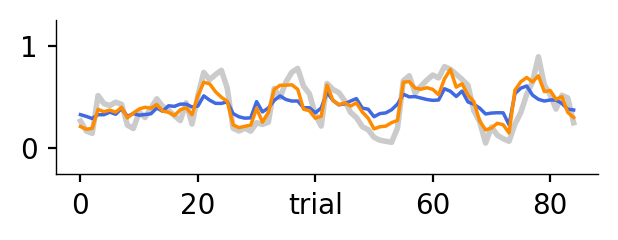

In [75]:
fig, ax = plt.subplots(1,1,figsize=(3.5,1))
ax.plot(test_Y.flatten()[:150], c="darkgrey", linewidth=2, alpha=.6)
ax.plot(linear_pred.flatten()[:150], c="royalblue", linewidth=1.25)
ax.plot(rrr_pred.detach().numpy().flatten()[:150], c="darkorange", linewidth=1.25)
ax.spines[['right', 'top']].set_visible(False)
ax.set_xticks([0,20,40,60,80], [0,20,"trial",60,80])
ax.set_ylim([-0.25, 1.25])
plt.savefig("./plots/prior_traces_2.png", dpi=200)